In [1]:
from typing import Tuple
import pandas as pd
from tqdm.notebook import tqdm
from evaluation.generated_dataset import GeneratedDataset, load_all_from_config
from evaluation.novelty import NoveltyFilter, filter_by_unique_structure

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


In [2]:
datasets = {
    #"WyckoffTransformer-raw": ("WyckoffTransformer",),
    "WyFormer": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyForDiffCSP++": ("WyckoffTransformer", "DiffCSP++", "CHGNet_fix"),
    "WyLLM-naive-DiffCSP++": ("WyckoffLLM-naive", "DiffCSP++"),
    "WyLLM-vanilla-DiffCSP++": ("WyckoffLLM-vanilla", "DiffCSP++"),
    "WyLLM-site-symmetry-DiffCSP++": ("WyckoffLLM-site-symmetry", "DiffCSP++"),
    #"WyckoffTransformer-free": ("WyckoffTransformer", "CrySPR", "CHGNet_free"),
    "CrystalFormer": ("CrystalFormer", "CHGNet_fix_release"),
    #"DiffCSP++ raw": ("DiffCSP++",),
    "DiffCSP++": ("DiffCSP++", "CHGNet_fix_release"),
    "DiffCSP": ("DiffCSP", "CHGNet_fix"),
    "FlowMM": ("FlowMM", "CHGNet_fix"),
    #"MP-20 train": ("split", "train"),
    #"MP-20 test": ("split", "test"),
}
raw_datasets = {
    "WyFormer": ("WyckoffTransformer", "CrySPR", "CHGNet_fix_release"),
    "WyFormerDiffCSP++": ("WyckoffTransformer", "DiffCSP++"),
    "WyLLM-DiffCSP++": ("WyckoffLLM-naive", "DiffCSP++"),
    "CrystalFormer": ("CrystalFormer",),
    "DiffCSP++": ("DiffCSP++",),
    "DiffCSP": ("DiffCSP",),
    "FlowMM": ("FlowMM",),
}

In [3]:
all_datasets = load_all_from_config(
    datasets=list(datasets.values()) + list(raw_datasets.values()) + \
        [("split", "train"), ("split", "val"), ("split", "test"), ("WyckoffTransformer", "CrySPR", "CHGNet_fix")],
    dataset_name="mp_20")

In [4]:
len(all_datasets[('split', 'train')].data) 

27136

In [5]:
wycryst_transformations = ('WyCryst', 'CrySPR', 'CHGNet_fix')
datasets["WyCryst"] = wycryst_transformations
raw_datasets["WyCryst"] = wycryst_transformations
all_datasets[wycryst_transformations] = GeneratedDataset.from_cache(wycryst_transformations, "mp_20_biternary")

In [6]:
excluded_categories = frozenset(["radioactive", "rare_earth_metal", "noble_gas"])
from pymatgen.core import Structure
def check_composition(structure: Structure) -> bool:
    for category in excluded_categories:
        if structure.composition.contains_element_type(category):
            return False
    return True

In [7]:
novelty_reference = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
novelty_filter = NoveltyFilter(novelty_reference)

In [8]:
import evaluation.statistical_evaluator
test_unique = filter_by_unique_structure(all_datasets[('split', 'test')].data)
test_novel = novelty_filter.get_novel(test_unique)
test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(test_novel)

In [9]:
import evaluation.novelty
train_w_template_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1))
train_strict_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1))
train_relaxed_AFLOW_set = frozenset(novelty_reference.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1))

In [10]:
def is_sg_preserved(relaxed_sg, transformations: Tuple[str]) -> pd.Series:
    source_sg = all_datasets[(transformations[0],)].data.spacegroup_number
    return relaxed_sg == source_sg.reindex_like(relaxed_sg)

In [11]:
mp_20 = pd.concat([
    all_datasets[('split', 'train')].data,
    all_datasets[('split', 'test')].data,
    all_datasets[('split', 'val')].data], axis=0, verify_integrity=True)
(mp_20.spacegroup_number == 1).mean()
mp_20.smact_validity.mean()

0.9057020937893829

In [12]:
1-mp_20.smact_validity.mean()

0.09429790621061707

In [13]:
mp_20.sites.apply(len).mean()

3.012403546397223

In [14]:
from collections import Counter
from operator import itemgetter
from itertools import chain
element_counts = Counter(chain(*mp_20.elements))

In [15]:
represented_elements=frozenset(map(itemgetter(0), element_counts.most_common(30)))

In [16]:
def check_represented_composition(structure: Structure) -> bool:
    for element in structure.composition:
        if element not in represented_elements:
            return False
    return True

In [17]:
def check_double_represented_composition(structure: Structure) -> bool:
    found_first_exotic = False
    for element in structure.composition:
        if element not in represented_elements:
            if found_first_exotic:
                return False
            found_first_exotic = True
    return True

In [18]:
mp_20.apply(check_represented_composition, axis=1).mean()

0.1901877114240863

In [19]:
mp_20.structure.apply(check_composition).mean()

/home/kna/.cache/pypoetry/virtualenvs/wyckofftransformer-FeCwefly-py3.12/lib/python3.12/site-packages/pymatgen/core/composition.py:548: FutureWarning: is_rare_earth_metal is deprecated, and will be removed on 2025-01-01
Use is_rare_earth in pymatgen.core.periodic_table instead.
is_rare_earth is corrected to include Y and Sc.
  return any(getattr(el, f"is_{category}") for el in self.elements)


0.5943089610648036

In [20]:
top_10_groups = frozenset(mp_20.spacegroup_number.value_counts().iloc[:10].index)
n_elements_dist = {}

Validity
1. Vanilla; Valid records: 2866 / 9648 = 29.71%
2. Naive; Valid records: 9492 / 9804 = 96.82%
3. Site Symmetry; Valid records: 8955 / 9709 = 92.23%

In [21]:
table = pd.DataFrame(
    index=datasets.keys(), columns=[
        "Novelty (%)",
        "Represented composition",
        "Structural", "Compositional", 
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements",
        "S.U.N. (%)",
        "R.S.U.N. (%)",
        "~R.S.U.N. (%)",
        "Top-10 S.U.N. (%)",
        "Novel Template (%)", 
        "Novel AFLOW on P1",
        "Novel AFLOW on !P1",
        "Novel AFLOW (%)",
        "Novel AFLOW relaxed (%)",
        "P1 (%)",
        "Space Group", "S.S.U.N. (%)"])
table.index.name = "Method"
E_hull_threshold = 0.08
for name, transformations in tqdm(datasets.items()):
    dataset = all_datasets[transformations]
    unique = filter_by_unique_structure(dataset.data)
    print(f"{name} unique: {len(unique)} / {len(dataset.data)} = {len(unique) / len(dataset.data) :.3%}")
    novel_template = ~unique.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set)
    table.loc[name, "Novel Template (%)"] = 100 * novel_template.mean()
    novel_aflow_strict = ~unique.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1).isin(train_strict_AFLOW_set)
    table.loc[name, "Novel AFLOW (%)"] = 100 * novel_aflow_strict.mean()
    novel_aflow_relaxed = ~unique.apply(evaluation.novelty.record_to_relaxed_AFLOW_fingerprint, axis=1).isin(train_relaxed_AFLOW_set)
    table.loc[name, "Novel AFLOW relaxed (%)"] = 100 * novel_aflow_relaxed.mean()
    unique_is_P1 = unique.group == 1
    table.loc[name, "Novel AFLOW on P1"] = 100 * novel_aflow_strict[unique_is_P1].mean()
    table.loc[name, "Novel AFLOW on !P1"] = 100 * novel_aflow_strict[~unique_is_P1].mean()
    if transformations == ("split", "train"):
        novel = unique
    else:
        novel = novelty_filter.get_novel(unique)
    table.loc[name, "Novelty (%)"] = 100 * len(novel) / len(unique)
    table.loc[name, "Represented composition"] = novel.structure.apply(check_represented_composition).mean()
    if "structural_validity" in novel.columns:
        table.loc[name, "Structural"] = 100 * novel.structural_validity.mean()
        table.loc[name, "Compositional"] = 100 * novel.smact_validity.mean()
    if "cdvae_crystal" in novel.columns:
        cov_metrics = test_evaluator.get_coverage(novel.cdvae_crystal)    
        table.loc[name, "Recall"] = 100 * cov_metrics["cov_recall"]
        table.loc[name, "Precision"] = 100 * cov_metrics["cov_precision"]
        novel = novel[novel.structural_validity]
        table.loc[name, r"$\rho$"] = test_evaluator.get_density_emd(novel)
        table.loc[name, "$E$"] = test_evaluator.get_cdvae_e_emd(novel)
        table.loc[name, "# Elements"] = test_evaluator.get_num_elements_emd(novel)
        n_elements_dist[name] = novel.elements.apply(lambda e: len(frozenset(e))).value_counts() / len(novel)
    table.loc[name, "P1 (%)"] = 100 * (novel.group == 1).mean()
    # table.loc[name, "# DoF"] = test_evaluator.get_dof_emd(novel)
    table.loc[name, "Space Group"] = test_evaluator.get_sg_chi2(novel)
    #try:
    #    table.loc[name, "SG preserved (%)"] = 100 * is_sg_preserved(novel.spacegroup_number, transformations).mean()
    #except KeyError:
    #    pass
    #table.loc[name, "Elements"] = test_evaluator.get_elements_chi2(novel)
    if "corrected_chgnet_ehull" in novel.columns:
        # S.U.N. is measured with respect to the initial structures
        has_ehull = dataset.data.corrected_chgnet_ehull.notna()
        data_is_represented = dataset.data.structure.apply(check_represented_composition)
        is_sun = (novel.corrected_chgnet_ehull <= E_hull_threshold) # & (novel.elements.apply(lambda x: len(frozenset(x))) >= 2)
        table.loc[name, "S.U.N. (%)"] = 100 * is_sun.sum() / has_ehull.sum()
        is_represented_novel = novel.structure.apply(check_represented_composition)
        table.loc[name, "R.S.U.N. (%)"] = 100 * (is_sun & is_represented_novel).sum() / (has_ehull & data_is_represented).sum()
        table.loc[name, "~R.S.U.N. (%)"] = 100 * (is_sun & ~is_represented_novel).sum() / (has_ehull & ~data_is_represented).sum()
        table.loc[name, "S.S.U.N. (%)"] = 100 * (is_sun & (novel.group != 1)).sum() / has_ehull.sum()
        has_ehull_top_10 = dataset.data[dataset.data.spacegroup_number.isin(top_10_groups)].corrected_chgnet_ehull.notna().sum()
        table.loc[name, "Top-10 S.U.N. (%)"] = 100 * is_sun[novel.spacegroup_number.isin(top_10_groups)].sum() / has_ehull_top_10
    if transformations == ("split", "train"):
        # Train forms the baseline of the hull
        test_dataset = all_datasets[("split", "test", "CHGNet_fix")].data
        test_with_ehull = test_dataset[test_dataset.corrected_chgnet_ehull.notna()]
        test_unique = filter_by_unique_structure(test_with_ehull)
        test_novel = novelty_filter.get_novel(test_unique)
        table.loc[name, "S.U.N. (%)"] = 100 * (test_novel.corrected_chgnet_ehull <= E_hull_threshold).sum() / len(test_with_ehull)
n_elements_dist["MP-20"] = mp_20.elements.apply(lambda e: len(frozenset(e))).value_counts() / len(mp_20)
table

  0%|          | 0/10 [00:00<?, ?it/s]

WyFormer unique: 1000 / 1000 = 100.000%
WyForDiffCSP++ unique: 1000 / 1000 = 100.000%
WyLLM-naive-DiffCSP++ unique: 994 / 996 = 99.799%
WyLLM-vanilla-DiffCSP++ unique: 567 / 999 = 56.757%
WyLLM-site-symmetry-DiffCSP++ unique: 998 / 999 = 99.900%
CrystalFormer unique: 988 / 992 = 99.597%
DiffCSP++ unique: 999 / 1000 = 99.900%
DiffCSP unique: 996 / 1000 = 99.600%
FlowMM unique: 994 / 997 = 99.699%
WyCryst unique: 994 / 994 = 100.000%


,Novelty (%),Represented composition,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements,S.U.N. (%),...,~R.S.U.N. (%),Top-10 S.U.N. (%),Novel Template (%),Novel AFLOW on P1,Novel AFLOW on !P1,Novel AFLOW (%),Novel AFLOW relaxed (%),P1 (%),Space Group,S.S.U.N. (%)
Method,,,,,,,,,,,,,,,,,,,,,
WyFormer,90.0,0.2,99.555556,80.444444,98.666667,96.715328,0.73714,0.053159,0.096566,38.938939,...,37.871287,44.190871,19.8,73.333333,35.463918,36.6,35.2,3.236607,0.222677,38.038038
WyForDiffCSP++,89.5,0.198883,99.664804,80.335196,99.217877,96.792745,0.665291,0.050328,0.098188,36.6,...,36.217553,39.314516,20.0,76.923077,36.068896,36.6,35.4,1.457399,0.211951,35.9
WyLLM-naive-DiffCSP++,94.668008,0.181722,99.78746,82.890542,98.724761,94.967927,0.387347,0.066829,0.015138,NaN,...,NaN,NaN,25.452716,46.153846,41.590214,41.649899,40.442656,1.384452,0.166642,NaN
WyLLM-vanilla-DiffCSP++,95.590829,0.765683,99.815498,88.745387,94.464945,59.666003,2.226501,0.233738,0.252778,NaN,...,NaN,NaN,26.80776,100.0,36.330935,37.566138,36.507937,2.033272,0.621334,NaN
WyLLM-site-symmetry-DiffCSP++,89.478958,0.231803,99.888018,83.87458,99.44009,96.317186,0.296908,NaN,0.037908,NaN,...,NaN,NaN,19.539078,40.0,35.071575,35.170341,32.264529,2.242152,0.158086,NaN
CrystalFormer,76.923077,0.221053,86.842105,82.368421,99.868421,95.13382,0.524171,0.099555,0.163017,33.870968,...,35.487959,36.6,9.716599,71.428571,26.694045,27.327935,26.417004,0.909091,0.276161,33.770161
DiffCSP++,89.68969,0.141741,100.0,85.044643,99.330357,95.79739,0.147837,0.036122,0.503632,41.4,...,40.801887,46.563193,1.001001,78.26087,29.303279,30.43043,28.828829,2.566964,0.25525,40.8
DiffCSP,90.060241,0.220736,100.0,80.936455,99.554069,96.206591,0.822378,0.052409,0.293636,57.4,...,57.48731,56.818182,9.538153,63.414634,33.832335,43.574297,42.871486,36.566332,7.988511,40.6
FlowMM,90.140845,0.183036,96.205357,82.477679,99.665179,96.361424,0.315307,0.044476,0.114668,49.548646,...,49.447853,54.464286,6.136821,49.888641,30.275229,39.134809,37.122736,49.303944,14.007995,29.889669


In [22]:
table.loc[:, ["Represented composition", "S.U.N. (%)", "R.S.U.N. (%)", "~R.S.U.N. (%)"]]

,Represented composition,S.U.N. (%),R.S.U.N. (%),~R.S.U.N. (%)
Method,,,,
WyFormer,0.2,38.938939,43.455497,37.871287
WyForDiffCSP++,0.198883,36.6,38.219895,36.217553
WyLLM-naive-DiffCSP++,0.181722,NaN,NaN,NaN
WyLLM-vanilla-DiffCSP++,0.765683,NaN,NaN,NaN
WyLLM-site-symmetry-DiffCSP++,0.231803,NaN,NaN,NaN
CrystalFormer,0.221053,33.870968,27.586207,35.487959
DiffCSP++,0.141741,41.4,44.736842,40.801887
DiffCSP,0.220736,57.4,57.075472,57.48731
FlowMM,0.183036,49.548646,50.0,49.447853


In [23]:
all_datasets[('split', 'test')].data.apply(evaluation.novelty.record_to_anonymous_fingerprint, axis=1).isin(train_w_template_set).mean()

0.9713685606898077

In [24]:
all_datasets[('split', 'test')].data.apply(evaluation.novelty.record_to_strict_AFLOW_fingerprint, axis=1).isin(train_strict_AFLOW_set).mean()

0.9328985186822906

In [25]:
n_elements_dist["MP-20"][2] + n_elements_dist["MP-20"][3]

0.7866192044926927

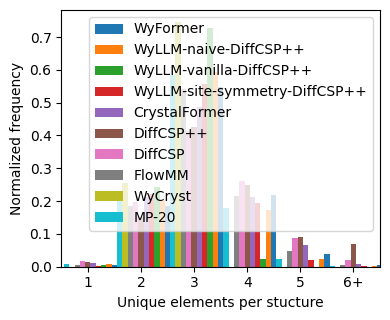

In [26]:
import matplotlib.pyplot as plt
fig_n_elements, ax_n_elements = plt.subplots(figsize=(4, 3.3))
width = 0.1
max_elements = 6
n_elemnts_to_plot = n_elements_dist.copy()
del n_elemnts_to_plot["WyForDiffCSP++"]
for plot_index, (name, dist) in enumerate(n_elemnts_to_plot.items()):
    adjusted_dist = dist.loc[dist.index <= max_elements].copy()
    if max_elements in adjusted_dist.index:
        adjusted_dist[max_elements] += dist.loc[dist.index > max_elements].sum()
    ax_n_elements.bar(adjusted_dist.index + (len(n_elemnts_to_plot) / 2 - plot_index) * width,
                      adjusted_dist, width, label=name)# EMD = {table.loc[name, "# Elements"]:.2f}")
ax_n_elements.set_xlabel("Unique elements per stucture")
ax_n_elements.set_ylabel("Normalized frequency")
ax_n_elements.legend()
ax_n_elements.set_xticks(range(1, max_elements + 1))
ax_n_elements.set_xlim(0.5, max_elements + 0.5)
x_ticks = list(range(1, max_elements)) + [f"{max_elements}+"]
ax_n_elements.set_xticklabels(x_ticks)
fig_n_elements.tight_layout()
fig_n_elements.savefig("plots/ICLR_rebuttal/unique_elements_distribution.pdf");

In [27]:
table[["Novel Template (%)", "Novel AFLOW on P1", "Novel AFLOW on !P1", "Novel AFLOW (%)", "Novelty (%)"]].style.format("{:.1f}")

,Novel Template (%),Novel AFLOW on P1,Novel AFLOW on !P1,Novel AFLOW (%),Novelty (%)
Method,,,,,
WyFormer,19.8,73.3,35.5,36.6,90.0
WyForDiffCSP++,20.0,76.9,36.1,36.6,89.5
WyLLM-naive-DiffCSP++,25.5,46.2,41.6,41.6,94.7
WyLLM-vanilla-DiffCSP++,26.8,100.0,36.3,37.6,95.6
WyLLM-site-symmetry-DiffCSP++,19.5,40.0,35.1,35.2,89.5
CrystalFormer,9.7,71.4,26.7,27.3,76.9
DiffCSP++,1.0,78.3,29.3,30.4,89.7
DiffCSP,9.5,63.4,33.8,43.6,90.1
FlowMM,6.1,49.9,30.3,39.1,90.1


In [28]:
table.to_csv("tables/paper_summary_table.csv")
table.to_pickle("tables/paper_summary_table.pkl")

In [29]:
max_subset=["Novelty (%)", "Structural", "Compositional", "Recall", "Precision", "S.S.U.N. (%)", "S.U.N. (%)", "Novel Template (%)"]
# -1 to exclude the MP-20 training set
def highlight_max_value(s):
    if s.name not in max_subset:
        return ['' for _ in s]
    is_max = s == s.max()
    #is_max.iloc[-1] = False
    return ['font-weight: bold' if v else '' for v in is_max]

min_subset=[r"$\rho$", "$E$", "# Elements", "# DoF", "Space Group", "Elements", "P1 (%)"]
def highlight_min_value(s):
    if s.name not in min_subset:
        return ['' for _ in s]
    is_min = s == s.min()
    #is_min.iloc[-1] = False
    return ['font-weight: bold' if v else '' for v in is_min]

In [30]:
def prettify(table):
    return table.style.format({
    "Novelty (%)": "{:.2f}",
    "Structural": "{:.2f}",
    "Compositional": "{:.2f}",
    "Recall": "{:.2f}",
    "Precision": "{:.2f}",
    r"$\rho$": "{:.2f}",
    "$E$": "{:.3f}",
    "# Elements": "{:.3f}",
    "# DoF": "{:.3f}",
    "Space Group": "{:.3f}",
    "Elements": "{:.3f}",
    "Novel Template (%)": "{:.2f}",
    "P1 (%)": "{:.2f}",
    "S.U.N. (%)": "{:.1f}",
    "S.S.U.N. (%)": "{:.1f}",
}).apply(highlight_max_value).apply(highlight_min_value)
prettify(table)

,Novelty (%),Represented composition,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements,S.U.N. (%),R.S.U.N. (%),~R.S.U.N. (%),Top-10 S.U.N. (%),Novel Template (%),Novel AFLOW on P1,Novel AFLOW on !P1,Novel AFLOW (%),Novel AFLOW relaxed (%),P1 (%),Space Group,S.S.U.N. (%)
Method,,,,,,,,,,,,,,,,,,,,,
WyFormer,90.00,0.200000,99.56,80.44,98.67,96.72,0.74,0.053,0.097,38.9,43.455497,37.871287,44.190871,19.80,73.333333,35.463918,36.600000,35.200000,3.24,0.223,38.0
WyForDiffCSP++,89.50,0.198883,99.66,80.34,99.22,96.79,0.67,0.050,0.098,36.6,38.219895,36.217553,39.314516,20.00,76.923077,36.068896,36.600000,35.400000,1.46,0.212,35.9
WyLLM-naive-DiffCSP++,94.67,0.181722,99.79,82.89,98.72,94.97,0.39,0.067,0.015,nan,nan,nan,nan,25.45,46.153846,41.590214,41.649899,40.442656,1.38,0.167,nan
WyLLM-vanilla-DiffCSP++,95.59,0.765683,99.82,88.75,94.46,59.67,2.23,0.234,0.253,nan,nan,nan,nan,26.81,100.000000,36.330935,37.566138,36.507937,2.03,0.621,nan
WyLLM-site-symmetry-DiffCSP++,89.48,0.231803,99.89,83.87,99.44,96.32,0.30,nan,0.038,nan,nan,nan,nan,19.54,40.000000,35.071575,35.170341,32.264529,2.24,0.158,nan
CrystalFormer,76.92,0.221053,86.84,82.37,99.87,95.13,0.52,0.100,0.163,33.9,27.586207,35.487959,36.600000,9.72,71.428571,26.694045,27.327935,26.417004,0.91,0.276,33.8
DiffCSP++,89.69,0.141741,100.00,85.04,99.33,95.80,0.15,0.036,0.504,41.4,44.736842,40.801887,46.563193,1.00,78.260870,29.303279,30.430430,28.828829,2.57,0.255,40.8
DiffCSP,90.06,0.220736,100.00,80.94,99.55,96.21,0.82,0.052,0.294,57.4,57.075472,57.487310,56.818182,9.54,63.414634,33.832335,43.574297,42.871486,36.57,7.989,40.6
FlowMM,90.14,0.183036,96.21,82.48,99.67,96.36,0.32,0.044,0.115,49.5,50.000000,49.447853,54.464286,6.14,49.888641,30.275229,39.134809,37.122736,49.30,14.008,29.9


In [31]:
prettify(table.iloc[:, :9]).to_latex("tables/summary_similarity_raw.tex", siunitx=True, convert_css=True)
prettify(table.iloc[:, 9:]).to_latex("tables/summary_symmetry_raw.tex", siunitx=True, convert_css=True)

In [32]:
raw_test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(all_datasets[('split', 'test')].data)
cdvae_table = pd.DataFrame(index=pd.Index(datasets.keys(), tupleize_cols=False),
    columns=[
        "Structural", "Compositional",
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements"])
sample_size = 992
for name, transformations in tqdm(datasets.items()):
    dataset = all_datasets[transformations]
    if "structure" in dataset.data.columns:
        cdvae_table.loc[name, "Compositional"] = 100*dataset.data.smact_validity.mean()
        cdvae_table.loc[name, "Structural"] = 100*dataset.data.structural_validity.mean()
        valid = dataset.data[dataset.data.naive_validity]
        cov_metrics = raw_test_evaluator.get_coverage(valid.cdvae_crystal)
        cdvae_table.loc[name, "Recall"] = 100*cov_metrics["cov_recall"]
        cdvae_table.loc[name, "Precision"] = 100*cov_metrics["cov_precision"]
        cdvae_table.loc[name, r"$\rho$"] = raw_test_evaluator.get_density_emd(valid)
        cdvae_table.loc[name, "$E$"] = raw_test_evaluator.get_cdvae_e_emd(valid)
        cdvae_table.loc[name, "# Elements"] = raw_test_evaluator.get_num_elements_emd(valid)
cdvae_table.to_csv("tables/cdvae_metrics_table.csv")
prettify(cdvae_table).to_latex("tables/cdvae_metrics_table.tex", siunitx=True, convert_css=True)
prettify(cdvae_table)

  0%|          | 0/10 [00:00<?, ?it/s]

,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements
WyFormer,99.60,81.40,98.77,95.94,0.39,0.078,0.081
WyForDiffCSP++,99.70,81.40,99.26,95.85,0.33,0.070,0.078
WyLLM-naive-DiffCSP++,99.80,83.33,98.91,94.09,0.19,0.090,0.029
WyLLM-vanilla-DiffCSP++,99.90,92.99,96.55,59.81,2.01,0.339,0.284
WyLLM-site-symmetry-DiffCSP++,99.90,84.38,99.76,95.48,0.09,nan,0.036
CrystalFormer,89.92,84.88,99.87,95.45,0.19,0.139,0.119
DiffCSP++,100.00,85.80,99.42,95.48,0.13,0.036,0.453
DiffCSP,100.00,82.50,99.64,95.18,0.46,0.075,0.321
FlowMM,96.59,83.25,99.75,95.83,0.17,0.055,0.107
WyCryst,99.90,82.09,99.63,96.16,0.44,0.330,0.322


In [33]:
raw_test_evaluator = evaluation.statistical_evaluator.StatisticalEvaluator(all_datasets[('split', 'test')].data)
cdvae_table = pd.DataFrame(index=pd.Index(raw_datasets.keys(), tupleize_cols=False),
    columns=[
        "Structural", "Compositional",
        "Recall", "Precision",
        r"$\rho$", "$E$", "# Elements"])
sample_size = 992
for name, transformations in tqdm(raw_datasets.items()):
    dataset = all_datasets[transformations]
    if "structure" in dataset.data.columns:
        cdvae_table.loc[name, "Compositional"] = 100*dataset.data.smact_validity.mean()
        cdvae_table.loc[name, "Structural"] = 100*dataset.data.structural_validity.mean()
        valid = dataset.data[dataset.data.naive_validity]
        cov_metrics = raw_test_evaluator.get_coverage(valid.cdvae_crystal)
        cdvae_table.loc[name, "Recall"] = 100*cov_metrics["cov_recall"]
        cdvae_table.loc[name, "Precision"] = 100*cov_metrics["cov_precision"]
        cdvae_table.loc[name, r"$\rho$"] = raw_test_evaluator.get_density_emd(valid)
        cdvae_table.loc[name, "$E$"] = raw_test_evaluator.get_cdvae_e_emd(valid)
        cdvae_table.loc[name, "# Elements"] = raw_test_evaluator.get_num_elements_emd(valid)
cdvae_table.to_csv("tables/cdvae_metrics_no_relax_table.csv")
prettify(cdvae_table).to_latex("tables/cdvae_metrics_no_relax_table.tex", siunitx=True, convert_css=True)
prettify(cdvae_table)

  0%|          | 0/8 [00:00<?, ?it/s]

,Structural,Compositional,Recall,Precision,$\rho$,$E$,# Elements
WyFormer,99.60,81.40,98.77,95.94,0.39,0.078,0.081
WyFormerDiffCSP++,99.80,81.40,99.51,95.81,0.36,0.083,0.079
WyLLM-DiffCSP++,99.80,83.33,98.91,94.09,0.19,0.090,0.029
CrystalFormer,93.39,84.98,99.62,94.56,0.19,0.208,0.128
DiffCSP++,99.94,85.13,99.67,99.54,0.31,0.069,0.399
DiffCSP,100.00,83.20,99.82,99.51,0.35,0.095,0.347
FlowMM,96.87,83.11,99.73,99.39,0.12,0.073,0.094
WyCryst,99.90,82.09,99.63,96.16,0.44,0.330,0.322
